# sprint21 TransferLearning(転移学習)

### データセット読み込み

In [1]:
ls ./fruits-360/

LICENSE  papers/  readme.md  Test/  test-multiple_fruits/  Training/


In [2]:
TRAIN_DIR = "./fruits-360/Training/"
TEST_DIR = "./fruits-360/Test/"

In [3]:
import glob
# from PIL import Image
import cv2
import numpy as np

def get_array_data_from_image(search_dir):

    x,y= [], []

    for name in glob.iglob(search_dir + "**/*.jpg"):
        # print(name)
        img = np.array(cv2.imread(name))
        
        x.append(img)
        # ディレクトリ名が正解ラベルになる
        y.append(name.split('/')[3])
    
    return np.array(x), np.array(y)

In [4]:
x_train, y_train_label = get_array_data_from_image(TRAIN_DIR)
x_test, y_test_label = get_array_data_from_image(TEST_DIR)

In [5]:
print(y_train_label.shape)
print(y_test_label.shape)

(37101,)
(12460,)


In [6]:
# 変換表を作成　
label_to_num = {}
for i, name in enumerate(np.sort(np.unique(y_test_label))):
    label_to_num[name] = i

In [7]:
y_train = np.array([label_to_num[name] for name in y_train_label])
y_test = np.array([label_to_num[name] for name in y_test_label])

In [13]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


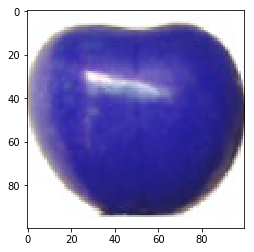

In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.imshow(x_train[2000])

In [8]:
print(y_train[2000])
print(y_train_label[2000])

20
Cherry 2


### 画素値を正規化

In [8]:
# floatに変換
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 正規化
x_train /= 255.0
x_test /= 255.0

### Onehot表現に変換

In [9]:
from keras.utils import np_utils

class_num = len(np.unique(y_test_label))

y_train_onehot = np_utils.to_categorical(y_train, class_num) 
y_test_onehot = np_utils.to_categorical(y_test, class_num) 

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### 転移学習１　VGG16

#### モデル構築

In [19]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam

transfer_model = VGG16(include_top=False, input_shape=x_train[0,:].shape)

# 全結合層手前のシェイプ
# 3, 3, 512

last_layers_model = Sequential()

last_layers_model.add(Flatten(input_shape=(3, 3, 512)))
last_layers_model.add(Dense(1024))
last_layers_model.add(Activation('relu'))
# last_layers_model.add(Dropout(0.3))
last_layers_model.add(Dense(74, activation='softmax'))

# 全結合層を削除したVGG16モデルと上で自前で構築した全結合層を結合
model = Model(input=transfer_model.input, output=last_layers_model(transfer_model.output))


# VGG16のみのモデルと
# model = Model(input=transfer_model.input, output=transfer_model.output)

# 学習しない（フリーズ）
for layer in model.layers:
        layer.trainable = False
        
model.layers[-1].trainable = True

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, decay=1e-6),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 10s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_poo

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


### 学習

In [21]:
history = model.fit(x_train, 
                                  y_train_onehot,
                                 batch_size=1000,
                                 epochs=5,
                                 validation_data=(x_test, y_test_onehot),
                                 verbose=1
                   )

Train on 37101 samples, validate on 12460 samples
Epoch 1/5
37101/37101 [==============================] - 193s 5ms/step - loss: 0.9688 - acc: 0.8157 - val_loss: 0.2713 - val_acc: 0.9305
Epoch 2/5
37101/37101 [==============================] - 125s 3ms/step - loss: 0.0592 - acc: 0.9905 - val_loss: 0.1565 - val_acc: 0.9612
Epoch 3/5
37101/37101 [==============================] - 125s 3ms/step - loss: 0.0333 - acc: 0.9939 - val_loss: 0.1284 - val_acc: 0.9682
Epoch 4/5
37101/37101 [==============================] - 126s 3ms/step - loss: 0.0233 - acc: 0.9939 - val_loss: 0.1119 - val_acc: 0.9705
Epoch 5/5
37101/37101 [==============================] - 125s 3ms/step - loss: 0.0195 - acc: 0.9940 - val_loss: 0.1190 - val_acc: 0.9715


### テストデータで精度を確認

In [26]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

np.sum( y_pred == y_true)/ len(y_test)

0.9715088282504013

### 逆引き辞書を作成（ラベルから数値へ）

In [10]:
num_to_label = { v: k for k, v in label_to_num.items()}

### 外れた画像を表示

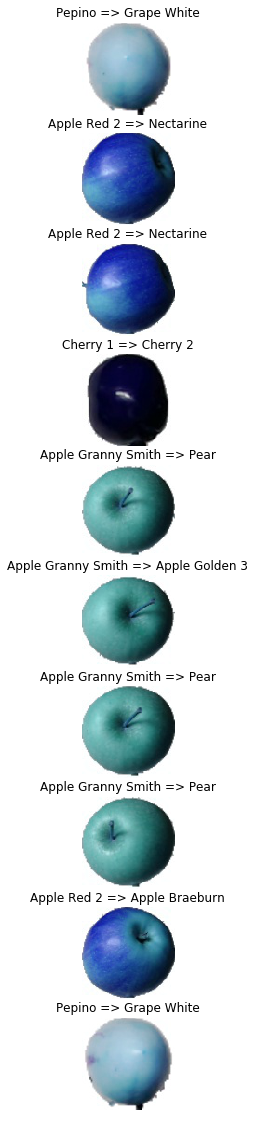

In [46]:
missing_index = np.array([i for i in range(len(y_test)) if y_pred[i] != y_true[i]])

# 重複無しで１０個選ぶ
sample_missing_index = np.random.choice(missing_index, 10, replace=False)

disp_num = len(sample_missing_index)

plt.figure(figsize=(100,20))
for i, miss_index in enumerate(sample_missing_index):
    plt.subplot(disp_num, 1, i+1)
    plt.axis("off")
    plt.imshow(x_test[miss_index])
    plt.title("{} => {}".format(num_to_label[y_true[miss_index]], num_to_label[y_pred[miss_index]]))

青系の果物や上から撮った画像に間違いが多いことがわかる。

In [43]:
len(missing_index)

355

### 転移学習2　InceptionV3

#### InceptionV3の最低サイズが (137,137)なので２倍にリサイズ

In [11]:
#Create 2 times big Image
def scale_x2(img):
    return cv2.resize(img, None, fx = 2, fy = 2)

x_train_x2 = np.array([scale_x2(img) for img in x_train])
x_test_x2 = np.array([scale_x2(img) for img in x_test])

In [12]:
# plt.imshow(x_train_x2[0])

NameError: name 'plt' is not defined

### モデル構築

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam


transfer_model =  InceptionV3(include_top=False, weights='imagenet', input_shape=x_train_x2[0].shape)

# 全結合層手前のシェイプ
# 3, 3, 2048

last_layers_model = Sequential()

# last_layers_model.add(Flatten(input_shape=transfer_model.output.shape))
last_layers_model.add(Flatten(input_shape=(4, 4, 2048)))
last_layers_model.add(Dense(1024))
last_layers_model.add(Activation('relu'))
# last_layers_model.add(Dropout(0.3))
last_layers_model.add(Dense(74, activation='softmax'))

# 全結合層を削除したInceptionV3モデルと上で自前で構築した全結合層を結合
model = Model(input=transfer_model.input, output=last_layers_model(transfer_model.output))


# InceptionV3のみのモデルと
# model = Model(input=transfer_model.input, output=transfer_model.output)
        
# 学習しない（フリーズ）
for layer in model.layers[:-1]:
    if 'BatchNormalization' not in str(layer):
        layer.trainable = False
        
model.layers[-1].trainable = True

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, decay=1e-6),
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [14]:
history = model.fit(x_train_x2, 
                                  y_train_onehot,
                                 batch_size=100,
                                 epochs=5,
                                 validation_data=(x_test_x2, y_test_onehot),
                                 verbose=1
                   )

Train on 37101 samples, validate on 12460 samples
Epoch 1/5
37101/37101 [==============================] - 480s 13ms/step - loss: 10.3598 - acc: 0.3416 - val_loss: 9.7748 - val_acc: 0.3620
Epoch 2/5
37101/37101 [==============================] - 486s 13ms/step - loss: 5.9686 - acc: 0.5974 - val_loss: 0.4351 - val_acc: 0.8909
Epoch 3/5
37101/37101 [==============================] - 487s 13ms/step - loss: 0.0644 - acc: 0.9801 - val_loss: 0.2939 - val_acc: 0.9292
Epoch 4/5
37101/37101 [==============================] - 485s 13ms/step - loss: 0.0529 - acc: 0.9838 - val_loss: 0.2854 - val_acc: 0.9339
Epoch 5/5
37101/37101 [==============================] - 485s 13ms/step - loss: 0.0190 - acc: 0.9914 - val_loss: 0.2351 - val_acc: 0.9416


In [13]:
def accuracy_score(x, y_onehot, model):
    y_pred = np.argmax(model.predict(x), axis=1)
    y_true = np.argmax(y_onehot, axis=1)

    return np.sum( y_pred == y_true)/ len(y_onehot)

In [16]:
accuracy_score(x_test_x2, y_test_onehot, model)

0.9415730337078652



### 転移学習３　resnet50

In [14]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam


transfer_model =  ResNet50(include_top=False, input_shape=x_train_x2[0].shape)

last_layers_model = Sequential()

last_layers_model.add(Flatten(input_shape=(1, 1, 2048)))
last_layers_model.add(Dense(1024))
last_layers_model.add(Activation('relu'))
# last_layers_model.add(Dropout(0.3))
last_layers_model.add(Dense(74, activation='softmax'))

# 全結合層を削除したResNet50モデルと上で自前で構築した全結合層を結合
resnet_model = Model(input=transfer_model.input, output=last_layers_model(transfer_model.output))

# ResNet50のみのモデル
# resnet_model = Model(input=transfer_model.input, output=transfer_model.output)

# 学習しない（フリーズ）
for layer in resnet_model.layers[:-1]:
    if 'BatchNormalization' not in str(layer):
        layer.trainable = False

# モデルのコンパイル
resnet_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, decay=1e-6),
              metrics=['accuracy'])

resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [15]:
history = resnet_model.fit(x_train_x2, 
                                  y_train_onehot,
                                 batch_size=100,
                                 epochs=5,
                                 validation_data=(x_test_x2, y_test_onehot),
                                 verbose=1
                   )

Train on 37101 samples, validate on 12460 samples
Epoch 1/5
37101/37101 [==============================] - 724s 20ms/step - loss: 0.1049 - acc: 0.9743 - val_loss: 7.9075 - val_acc: 0.1165
Epoch 2/5
37101/37101 [==============================] - 718s 19ms/step - loss: 0.3465 - acc: 0.9643 - val_loss: 0.6271 - val_acc: 0.8770
Epoch 3/5
37101/37101 [==============================] - 717s 19ms/step - loss: 0.4880 - acc: 0.9588 - val_loss: 0.4663 - val_acc: 0.9586
Epoch 4/5
37101/37101 [==============================] - 717s 19ms/step - loss: 0.8883 - acc: 0.9356 - val_loss: 0.9223 - val_acc: 0.9267
Epoch 5/5
37101/37101 [==============================] - 717s 19ms/step - loss: 0.8875 - acc: 0.9375 - val_loss: 0.8925 - val_acc: 0.9351


In [16]:
accuracy_score(x_test_x2, y_test_onehot, resnet_model)

0.9350722311396469

In [60]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                   x_test| 373800144|
|                  x_train|1113030144|
|               x_train_x2|17808480144|
|                   y_test|     99776|
|             y_test_label|    947056|
|                y_test_x2|     37128|
|                  y_train|    296904|
|            y_train_label|   2819772|
|               y_train_x2|    110240|


### CNNでの実装

In [70]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.optimizers import Adam

from keras.layers.core import Dense, Activation, Dropout, Flatten

cnn_model = Sequential()

cnn_model.add(Conv2D(32, 3, input_shape=(100, 100, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, 3))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(1024))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(class_num, activation='softmax'))

# オプティマイザの設定
adam = Adam(lr=1e-3)

cnn_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_379 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
activation_532 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_380 (Conv2D)          (None, 47, 47, 64)        18496     
_________________________________________________________________
activation_533 (Activation)  (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 33856)             0         
__________

In [72]:
history = cnn_model.fit(x_train, 
                                  y_train_onehot,
                                 batch_size=1000,
                                 epochs=5,
                                 validation_data=(x_test, y_test_onehot),
                                 verbose=1
                   )

Train on 37101 samples, validate on 12460 samples
Epoch 1/5
37101/37101 [==============================] - 43s 1ms/step - loss: 2.1559 - acc: 0.4650 - val_loss: 0.4953 - val_acc: 0.8618
Epoch 2/5
37101/37101 [==============================] - 30s 817us/step - loss: 0.2173 - acc: 0.9378 - val_loss: 0.1955 - val_acc: 0.9343
Epoch 3/5
37101/37101 [==============================] - 30s 818us/step - loss: 0.0634 - acc: 0.9825 - val_loss: 0.1487 - val_acc: 0.9498
Epoch 4/5
37101/37101 [==============================] - 30s 818us/step - loss: 0.0362 - acc: 0.9894 - val_loss: 0.1175 - val_acc: 0.9535
Epoch 5/5
37101/37101 [==============================] - 30s 820us/step - loss: 0.0250 - acc: 0.9919 - val_loss: 0.1333 - val_acc: 0.9534


In [80]:
accuracy_score(x_test, y_test_onehot, cnn_model)

0.9533707865168539

### ただのDNN

In [83]:
from keras.layers import BatchNormalization 

dnn_model = Sequential()

dnn_model.add(Flatten(input_shape=(100, 100, 3)))
dnn_model.add(Dense(1024))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(1024))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(class_num, activation='softmax'))

# オプティマイザの設定
adam = Adam(lr=1e-3)

dnn_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

dnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
batch_normalization_377 (Bat (None, 1024)              4096      
_________________________________________________________________
activation_535 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_378 (Bat (None, 1024)              4096      
__________

In [84]:
history = dnn_model.fit(x_train, 
                                  y_train_onehot,
                                 batch_size=1000,
                                 epochs=5,
                                 validation_data=(x_test, y_test_onehot),
                                 verbose=1)

Train on 37101 samples, validate on 12460 samples
Epoch 1/5
37101/37101 [==============================] - 21s 572us/step - loss: 1.5564 - acc: 0.6000 - val_loss: 2.1258 - val_acc: 0.4581
Epoch 2/5
37101/37101 [==============================] - 11s 298us/step - loss: 0.3429 - acc: 0.9137 - val_loss: 2.3649 - val_acc: 0.4173
Epoch 3/5
37101/37101 [==============================] - 11s 292us/step - loss: 0.1421 - acc: 0.9696 - val_loss: 1.6106 - val_acc: 0.5819
Epoch 4/5
37101/37101 [==============================] - 11s 292us/step - loss: 0.0856 - acc: 0.9823 - val_loss: 1.8489 - val_acc: 0.5558
Epoch 5/5
37101/37101 [==============================] - 11s 293us/step - loss: 0.0595 - acc: 0.9865 - val_loss: 1.3743 - val_acc: 0.6491


In [85]:
accuracy_score(x_test, y_test_onehot, dnn_model)

0.6491171749598715

### 結果（精度順）

#### VGG16          97 %

#### (自作)CNN              95.3%

#### InceptionV3 94.1%

#### ResNet          93.5%

#### (自作）DNN              64.9%


### 分かったこと

InceptionV3やResNetは層がかなり深いため途中のBatchNormalization層の学習をしないと元の訓練データ（Image）と同じようなスケールでない場合勾配消失が発生しうまくいかないことが分かった。

BatchNormalization層を学習させると適切にスケーリングしてくれるため精度が出るようになった。

### 課題

InceptionV3、ResNetは画像の拡大のためバッチサイズを１０００から１００に変更した。
このため各イテレーションで訓練データをランダムで選ぶ設定を入れたほうがよいと思われる。



### ファインチューニング　VGG16

学習済みの重みをさらに学習させる

In [11]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam


transfer_model = VGG16(include_top=False, input_shape=x_train[0,:].shape)

# 全結合層手前のシェイプ
# (3, 3, 512)

last_layers_model = Sequential()

last_layers_model.add(Flatten(input_shape=(3, 3, 512)))
last_layers_model.add(Dense(1024))
last_layers_model.add(Activation('relu'))
# last_layers_model.add(Dropout(0.3))
last_layers_model.add(Dense(74, activation='softmax'))

# 全結合層を削除したVGG16モデルと上で自前で構築した全結合層を結合
vgg16_fine= Model(input=transfer_model.input, output=last_layers_model(transfer_model.output))


# VGG16のみのモデルと
# model = Model(input=transfer_model.input, output=transfer_model.output)

# # 学習しない（フリーズ）
# for layer in model.layers:
# #         layer.trainable = False
        
# model.layers[-1].trainable = True

# モデルのコンパイル
vgg16_fine.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, decay=1e-6),
              metrics=['accuracy'])

vgg16_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [13]:
history = vgg16_fine.fit(x_train, 
                                  y_train_onehot,
                                 batch_size=100,
                                 epochs=3,
                                 validation_data=(x_test, y_test_onehot),
                                 verbose=1
                   )

Train on 37101 samples, validate on 12460 samples
Epoch 1/3
37101/37101 [==============================] - 279s 8ms/step - loss: 2.1144 - acc: 0.4664 - val_loss: 0.7257 - val_acc: 0.8156
Epoch 2/3
37101/37101 [==============================] - 273s 7ms/step - loss: 0.1556 - acc: 0.9485 - val_loss: 1.3548 - val_acc: 0.6894
Epoch 3/3
37101/37101 [==============================] - 272s 7ms/step - loss: 0.1637 - acc: 0.9606 - val_loss: 0.3950 - val_acc: 0.9181


#### ファインチューニングよりも学習済みの重みを使ったほうが早くテストデータでのスコアが上昇し、転移学習が有用なことが確認できた。